In [77]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
from matplotlib import gridspec

def get_pairs(filename):
    pairs = []
    distance = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    for l in lines:
        if l.startswith('No'):
            m = re.match(r"No.(\d+):([a-zA-Z]+)([\d]+)\[*([a-z0-9]*)_*([a-z0-9\^\-]*)\]*->([a-zA-Z]+)([\d]+)\[*([a-z0-9]*)_*([a-z0-9\^\-]*)\]*\(([\d.]+)\)\n", l)
            if m:
                pairs.append([m.group(2), m.group(3), m.group(4), m.group(5), m.group(6), m.group(7), m.group(8), m.group(9)])
                distance.append(float(m.group(10)))
    orbitals = []
    for pair in pairs:
        if pair[2] != '':
            orbitals.append((pair[0], pair[1], pair[2], '', pair[4], pair[5], pair[6], ''))
            
    unique_orbitals = []
    for i in orbitals:
        if i not in unique_orbitals:
            unique_orbitals.append(i)
    return pairs, distance, unique_orbitals

def get_nedos(filename):
    with open(filename,'r') as f:
        lines = f.readlines()
    return int(lines[1].split()[2])

def get_energy_grid(filename):
    with open(filename,'r') as f:
        lines = f.readlines()
    pairs, dummy, dummy = get_pairs(filename)
    nedos = int(lines[1].split()[2])
    energy = np.zeros(nedos)
    for i, l in enumerate(lines[3+len(pairs):]):
        energy[i] = float(l.split()[0])
    return energy
        
def get_ave_pcohp(filename, spin=True):
    """
    return nedos*4 matrix if spin-polarized, nedos*2 if not
    1: up spin -> pCOHP averaged over all atom pairs specified
    2: up spin -> integrated pCOHP (IpCOHP) averaged over all atom pairs
    3: down spin -> pCOHP averaged over all atom pairs specified
    4: down spin -> integrated pCOHP (IpCOHP) averaged over all atom pairs  
    """
    with open(filename,'r') as f:
        lines = f.readlines()
    pairs, dummy, dummy = get_pairs(filename)
    nedos = int(lines[1].split()[2])
    if spin:
        ave_pcohp = np.zeros((nedos,4))
    else:
        ave_pcohp = np.zeros((nedos,2))
    for i, l in enumerate(lines[3+len(pairs):]):
        ave_pcohp[i][0] = float(l.split()[1])
        ave_pcohp[i][1] = float(l.split()[2])
        if spin:
            ave_pcohp[i][2] = float(l.split()[2*len(pairs)+3])
            ave_pcohp[i][3] = float(l.split()[2*len(pairs)+4])   
    return ave_pcohp

def get_pcohp(filename, spin=True):
    with open(filename,'r') as f:
        lines = f.readlines()
    pairs, dummy, dummy = get_pairs(filename)
    nedos = int(lines[1].split()[2])
    if spin:
        pcohp = np.zeros((nedos,len(pairs)*4))
    else:
        pcohp = np.zeros((nedos,len(pairs)*2))
    for i, l in enumerate(lines[3+len(pairs):]):
        for j in range(len(pairs)):
            pcohp[i][2*j] = l.split()[3+2*j]
            pcohp[i][2*j+1] = l.split()[3+2*j+1]
        if spin:
            for j in range(len(pairs)):
                pcohp[i][2*j+2*len(pairs)] = l.split()[5+2*j+2*len(pairs)]
                pcohp[i][2*j+1+2*len(pairs)] = l.split()[5+2*j+1+2*len(pairs)]      
    return pcohp

def plotcohp(filename, cohp=True, threshold=0):
    pairs, dummy, orbitals = get_pairs(filename)
    e = get_energy_grid(filename)
    pcohp = get_pcohp(filename)
    
    #plt.figure(figsize=(6,8))
    STYLES = ['solid', 'dotted']
    COLORS = ['C'+str(i) for i in range(10)]
    
    for j in range(len(orbitals)):
        pcohpsum = np.zeros(len(e))
        for i in range(len(pairs)):
            if pairs[i][0]==orbitals[j][0] and pairs[i][1]==orbitals[j][1] and pairs[i][2]==orbitals[j][2] and\
               pairs[i][4]==orbitals[j][4] and pairs[i][5]==orbitals[j][5] and pairs[i][6]==orbitals[j][6]:
                pcohpsum += pcohp[:, i*2]
        if sum(abs(pcohpsum)>=threshold)>=1:
            if cohp:
                lines = plt.plot(-pcohpsum, e, label=orbitals[j][0]+orbitals[j][2]+'/'+orbitals[j][4]+orbitals[j][6], lw=3)
            else:
                lines = plt.plot(pcohpsum, e, label=orbitals[j][0]+orbitals[j][2]+'/'+orbitals[j][4]+orbitals[j][6], lw=3)
            lines[0].set_color(COLORS[j%len(COLORS)])
            lines[0].set_linestyle(STYLES[j//len(COLORS)])  
            
    if cohp:
        plt.xlabel("-COHP")
    else:
        plt.xlabel("COOP")
    plt.ylabel("Energy(eV)")
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    #plt.show()

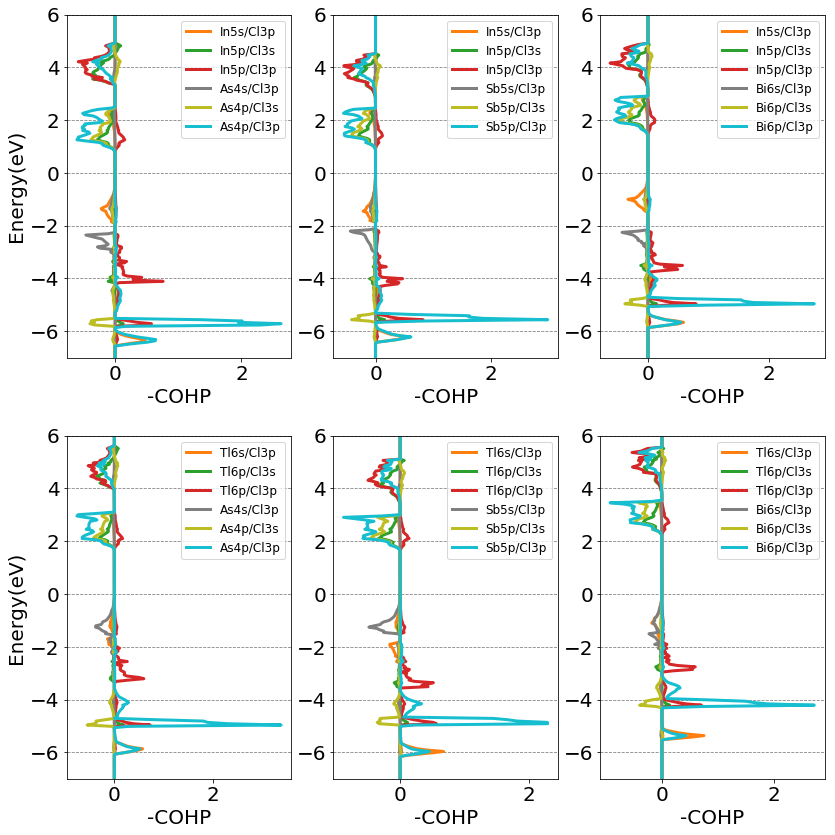

In [114]:
#filename = "/Users/yao/Google Drive/data/2116/lobster/Cs2Au1Sb1Cl6/COOPCAR.lobster"
#plotcohp(filename, False, 0.01)

B1_list = ['Cu','Ag','Au', 'In','Tl']
B2_list = ['Sc', 'Y', 'Al','Ga','In','Tl', 'As','Sb','Bi']
B1 = B1_list[3:5]
B2 = B2_list[6:9]
ylim = [-7, 6]
threshold = 0.2
legendsize = 12

fig = plt.figure(figsize=(4*len(B2),6*len(B1)))
gs = gridspec.GridSpec(len(B1), len(B2))
i = 0
for b1 in B1:
    for b2 in B2:
        try:
            filename = "/Users/yao/Google Drive/data/2116/lobster/Cs2"+b1+"1"+b2+"1Cl6/COHPCAR.lobster"
            plt.subplot(gs[i])
            plotcohp(filename, True, threshold)
            plt.ylim(ylim)
            plt.legend(prop={'size': legendsize})
            if i%len(B2) != 0:
                plt.ylabel("")
        except:
            print('not completed calculation')
        i += 1
        
        
plt.tight_layout(w_pad=0.1)
plt.savefig("/Users/yao/Google Drive/data/2116/2116 figure/full_data/cohp6.pdf", dpi=300, bbox_inches='tight')
plt.show()